In [2]:
import pandas as pd
import numpy as np
import json
import gensim

import nltk
from nltk import word_tokenize
from nltk import FreqDist
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn import svm

import scipy.stats as stats

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

## NLP Analyses

In [4]:
event_data=pd.read_csv('eventdata.csv',header=None)
question_data=pd.read_csv('questiondata.csv',header=None)

In [5]:
trial_data=pd.read_csv('trialdata.csv',header=None)

In [6]:
approved=[]
for worker in np.unique(trial_data[0]):
    columns=np.where(trial_data[0]==worker)[0]
    #print(worker)
    #print(len(columns))
    #print()
    if len(columns) >=120:
        approved.append(worker)
        
print(approved)
print(len(approved))

['A10IUXCZBNYUXC:3570Y55XZTC3DWSQ1WJQDI6YQPMGYV', 'A11JQI8VXU2NLP:3I3WADAZ9UXT3LZ4EDR17UH7M69O5A', 'A1CMDCHS6TMIHU:3FFJ6VRIL5HKCS20JC8K62PUSI60IY', 'A1QD1HNJRW4F6G:3SB4CE2TJZOD30PDA05EYIOMQH3AXH', 'A20C6NABP72OGJ:3SLE99ER0R67R5UKHWTVQEO3G5PZBD', 'A22ZYDQ7VRH6EL:3I2PTA7R3XNZ6GXN0DNBYOVPXRMKQM', 'A2IJICIKFSN1OO:33LK57MYLXY68RBMSIFQG3Y3KUKSZI', 'A2TRC2VHB7EZHK:3WI0P0II65LR4B6DLBQOZ1A4A2UDR3', 'A2VLTSW6CXIUMR:3TXD01ZLD8A6K7F1WUK0183I4QY4UI', 'A2WTKP7WMDN1:3LOZAJ85YH6OYXU9XLCZS05ODTU2XK', 'A365SN61J4UNGR:39ZSFO5CACPWNPYMZ1747AS1MMIUJR', 'A3G2LWO9G15LHN:3AQF3RZ55CBVGCMPKTIGC6MTQS3F6P', 'A3HO117NQN73GE:3FFJ6VRIL5HKCS20JC8K62PUSI60IY', 'A3K9GTQBOI7O5A:3UOUJI6MTH7XI93BG5M5YJ0GWKDXUX', 'A3O0ZQMDKOKAMR:3GLB5JMZF1O0FLXZ50WC0XWX7V3GDX', 'A58208A71VGW:3G2UL9A02H7I1J7J2AK4OE9CS4D675', 'A6QDP0HAGE9W5:3GLB5JMZF1O0FLXZ50WC0XWX8TJGDA', 'A9PW4DCG5CRXN:3MB8LZR5BJMOFJHA88FFH2WVOJ2LKY', 'AJ7STTIJWZU00:3TU5ZICBRHUFBFVMROQ88JMY3PV8QR', 'AKQAI78JTXXC9:3TYCR1GOTGCJ4EGW89IP4HK8S0CLZX', 'AKUKGG6UBRCBS:3TVRFO09GO8U

In [6]:
## Manual exclusion of bad participant
questionable_ppts=np.array(
    ['A2WTKP7WMDN1:3LOZAJ85YH6OYXU9XLCZS05ODTU2XK', # everything was "square will be move" or "ball will be move"
     'A3G2LWO9G15LHN:3AQF3RZ55CBVGCMPKTIGC6MTQS3F6P', # all caps "red ball is moving" or "red ball moved well"
     'A2TRC2VHB7EZHK:3WI0P0II65LR4B6DLBQOZ1A4A2UDR3', # just named objects in the scene
     'A6QDP0HAGE9W5:3GLB5JMZF1O0FLXZ50WC0XWX8TJGDA', # just named objects in the scene
     'A20C6NABP72OGJ:3SLE99ER0R67R5UKHWTVQEO3G5PZBD', # all but the first 3 were "there are 2 objects"
     'AKUKGG6UBRCBS:3TVRFO09GO8UZJGH7RU47W4XK0ELX0', # just named objects in the scene
     'A2IJICIKFSN1OO:33LK57MYLXY68RBMSIFQG3Y3KUKSZI', # just named objects in the scene
     'A11JQI8VXU2NLP:3I3WADAZ9UXT3LZ4EDR17UH7M69O5A' # just named objects in the scene
    ])
                   
# others:
#'AUB2Y0SIDWZEV:3NVC2EB65US2JKG26HC6UOHPMCK3YX', # will be move

final_ppts=[i for i in approved if i not in questionable_ppts]
print(final_ppts)
print(len(final_ppts))

['A10IUXCZBNYUXC:3570Y55XZTC3DWSQ1WJQDI6YQPMGYV', 'A1CMDCHS6TMIHU:3FFJ6VRIL5HKCS20JC8K62PUSI60IY', 'A1QD1HNJRW4F6G:3SB4CE2TJZOD30PDA05EYIOMQH3AXH', 'A22ZYDQ7VRH6EL:3I2PTA7R3XNZ6GXN0DNBYOVPXRMKQM', 'A2VLTSW6CXIUMR:3TXD01ZLD8A6K7F1WUK0183I4QY4UI', 'A365SN61J4UNGR:39ZSFO5CACPWNPYMZ1747AS1MMIUJR', 'A3HO117NQN73GE:3FFJ6VRIL5HKCS20JC8K62PUSI60IY', 'A3K9GTQBOI7O5A:3UOUJI6MTH7XI93BG5M5YJ0GWKDXUX', 'A3O0ZQMDKOKAMR:3GLB5JMZF1O0FLXZ50WC0XWX7V3GDX', 'A58208A71VGW:3G2UL9A02H7I1J7J2AK4OE9CS4D675', 'A9PW4DCG5CRXN:3MB8LZR5BJMOFJHA88FFH2WVOJ2LKY', 'AJ7STTIJWZU00:3TU5ZICBRHUFBFVMROQ88JMY3PV8QR', 'AKQAI78JTXXC9:3TYCR1GOTGCJ4EGW89IP4HK8S0CLZX', 'AUB2Y0SIDWZEV:3NVC2EB65US2JKG26HC6UOHPMCK3YX']
14


In [54]:
indices_2_use=[]
for worker in final_ppts: # Final participants
    indices_2_use.extend(np.where(question_data[0]==worker)[0])
    
actual_question_data=question_data.iloc[indices_2_use,:]
actual_question_data.columns=['id','question','answer']

actual_question_data=actual_question_data.pivot(index='id',columns='question',values='answer')
actual_question_data.head()

question,comments,difficulty,engagement,instructionloops,switch_tabs,vid_quality
id,,,,,,
A10IUXCZBNYUXC:3570Y55XZTC3DWSQ1WJQDI6YQPMGYV,"No, everything went fine.",4,6,1,No,Yes
A1CMDCHS6TMIHU:3FFJ6VRIL5HKCS20JC8K62PUSI60IY,no,6,7,2,Yes,Yes
A1QD1HNJRW4F6G:3SB4CE2TJZOD30PDA05EYIOMQH3AXH,Interesting task,1,10,1,No,Yes
A22ZYDQ7VRH6EL:3I2PTA7R3XNZ6GXN0DNBYOVPXRMKQM,I believe the estimated time should be adjuste...,2,10,1,No,Yes
A2VLTSW6CXIUMR:3TXD01ZLD8A6K7F1WUK0183I4QY4UI,I only switched tabs to check the time or to c...,7,10,1,Yes,Yes


<BarContainer object of 2 artists>

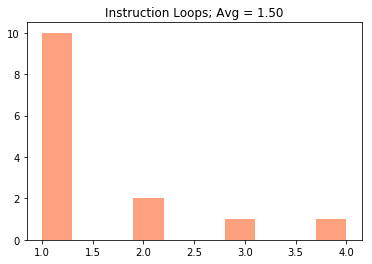

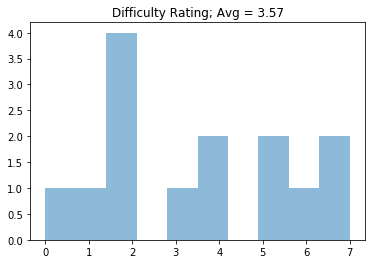

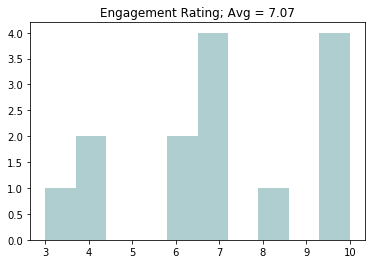

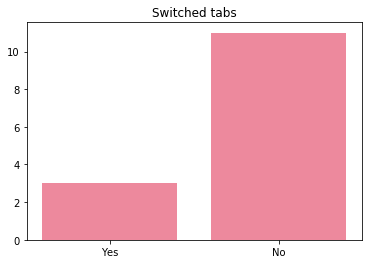

In [80]:
plt.figure()
plt.title('Instruction Loops; Avg = %0.2f' % np.nanmean(np.array(actual_question_data['instructionloops'],dtype=int)))
plt.hist(np.array(actual_question_data['instructionloops'],dtype=int),alpha=0.5,color='orangered')

plt.figure()
plt.title('Difficulty Rating; Avg = %0.2f' % np.nanmean(np.array(actual_question_data['difficulty'],dtype=int)))
plt.hist(np.array(actual_question_data['difficulty'],dtype=int),alpha=0.5)

plt.figure()
plt.title('Engagement Rating; Avg = %0.2f' % np.nanmean(np.array(actual_question_data['engagement'],dtype=int)))
plt.hist(np.array(actual_question_data['engagement'],dtype=int),alpha=0.5,color='cadetblue')

plt.figure()
plt.title('Switched tabs')
yes_no=np.hstack((np.sum(np.array(actual_question_data['switch_tabs'])=='Yes'),
                 np.sum(np.array(actual_question_data['switch_tabs'])=='No')))
plt.bar(['Yes','No'],yes_no,alpha=0.5,color='crimson')

### Create the dataframe

In [27]:
indices_2_use=[]
for worker in final_ppts: # Final participants
    indices_2_use.extend(np.where(trial_data[0]==worker)[0])
    
actual_data=trial_data.iloc[indices_2_use,:]

In [26]:
for idx in actual_data.index:
    actual_data[3][idx]=json.loads(actual_data[3][idx])
    
actual_data.head()
np.save('trialdata_dict',actual_data,allow_pickle=True)

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Load in 

In [7]:
nltk.download('stopwords')
eng_stopwords=stopwords.words("english")
my_stops=['green','blue','red','ball','plank','square','rectangle','box','cube','block'] #,'ramp']

for stop in my_stops:
    eng_stopwords.append(stop)

[nltk_data] Downloading package stopwords to /home/tsy6/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
remove=['against', 'between', 'through', 'during', 
        'before', 'after', 'above', 'below', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under' ]

eng_stopwords=[i for i in eng_stopwords if i not in remove]
print(len(eng_stopwords))
print(eng_stopwords)

172
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'into', 'to', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'ar

In [10]:
actual_data=np.load('trialdata_dict.npy',allow_pickle=True)

In [11]:
real_trials=[x for x in actual_data[:,3] if 'TrialName' in x]
print(len(real_trials))

1680


In [12]:
trial_types=['collision','containment','occlusion','falling','topple','rolling','sliding']

organized_types=[]
organized_trials=[]

failed_trials=[]
failed_types=[]

for trial in real_trials:
    for t, trial_type in enumerate(trial_types):
        #print(trial_type)
        if trial_type in trial['TrialName']:
            if 'success' in trial['TrialName'] or trial_type=='rolling' or trial_type=='sliding':
                organized_trials.append(trial['Response'])
                organized_types.append(t)
            else:
                failed_trials.append(trial['Response'])
                failed_types.append(t)
                break
organized_types=np.array(organized_types)
organized_trials=np.array(organized_trials)  

failed_types=np.array(failed_types)
failed_trials=np.array(failed_trials)
print('Successes:',len(organized_trials))
print('Fails:',len(failed_trials))

Successes: 910
Fails: 770


<BarContainer object of 7 artists>

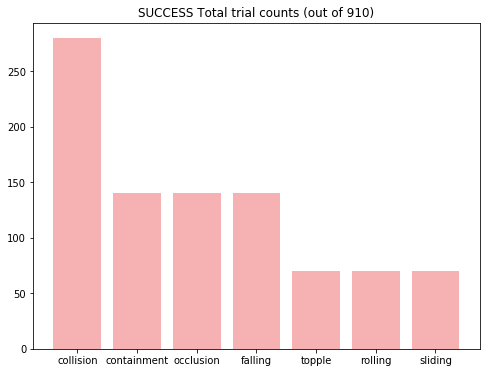

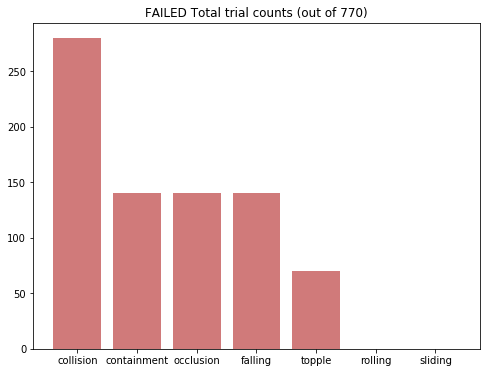

In [13]:
sums_success=[]
sums_fail=[]
for i in range(7):
    sums_success.append(np.sum(organized_types==i))
    sums_fail.append(np.sum(np.array(failed_types)==i))

plt.figure(figsize=(8,6))
plt.title('SUCCESS Total trial counts (out of %s)' % sum(sums_success))
plt.bar(trial_types,sums_success,alpha=0.6,color='lightcoral')

plt.figure(figsize=(8,6))
plt.title('FAILED Total trial counts (out of %s)' % sum(sums_fail))
plt.bar(trial_types,sums_fail,alpha=0.6,color='firebrick')

In [14]:
vector_input=[]
vector_input_fail=[]
for t, trial_type in enumerate(trial_types):
    print('success',trial_type)
    vector_input.append('\n'.join(organized_trials[organized_types==t]))
    
    print('fail',trial_type)
    vector_input_fail.append('\n'.join(failed_trials[failed_types==t]))
    
all_text='\n'.join(vector_input)

success collision
fail collision
success containment
fail containment
success occlusion
fail occlusion
success falling
fail falling
success topple
fail topple
success rolling
fail rolling
success sliding
fail sliding


In [15]:
vector_clean=[]
vector_clean_fail=[]
for t, trial_type in enumerate(trial_types):
    
    for v, vector in enumerate([vector_input,vector_input_fail]):

        words=word_tokenize(vector[t])
        
        words_clean=[]
        for w in words:
            if w.lower() not in eng_stopwords:
                if w.isalpha():
                    words_clean.append(w.lower())
        if v==0:
            print('Success')
            vector_clean.append(" ".join(words_clean))
        else:
            print('Fail')
            vector_clean_fail.append(" ".join(words_clean))
            
        fDist=FreqDist(words_clean)

        #fDist.plot(10)
        print(trial_type)
        print(fDist.most_common(10))
        
    print()

Success
collision
[('hits', 56), ('rolls', 47), ('screen', 41), ('slides', 40), ('hit', 33), ('rolling', 33), ('hitting', 33), ('left', 32), ('slowly', 30), ('slightly', 29)]
Fail
collision
[('behind', 69), ('rolls', 50), ('slides', 47), ('past', 44), ('left', 42), ('cross', 36), ('screen', 28), ('moving', 28), ('across', 25), ('moved', 25)]

Success
containment
[('cup', 74), ('down', 64), ('ramp', 55), ('bucket', 26), ('slides', 25), ('rolls', 23), ('on', 21), ('in', 19), ('fall', 18), ('flow', 16)]
Fail
containment
[('down', 54), ('ramp', 54), ('on', 43), ('cup', 36), ('in', 35), ('stuck', 27), ('rolls', 27), ('slides', 24), ('bucket', 20), ('from', 20)]

Success
occlusion
[('behind', 65), ('wall', 44), ('rolls', 25), ('slides', 22), ('moving', 18), ('cross', 17), ('left', 14), ('towards', 14), ('fast', 12), ('inside', 12)]
Fail
occlusion
[('wall', 42), ('rolls', 27), ('front', 27), ('in', 26), ('left', 24), ('slides', 23), ('past', 17), ('cross', 17), ('screen', 16), ('across', 15)]

Success trials


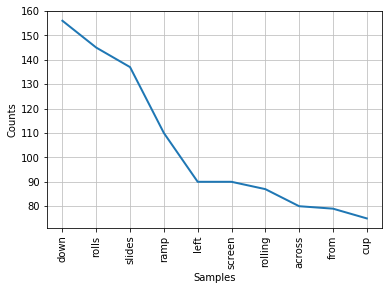

[('down', 156), ('rolls', 145), ('slides', 137), ('ramp', 110), ('left', 90), ('screen', 90), ('rolling', 87), ('across', 80), ('from', 79), ('cup', 75)]
Fail trials


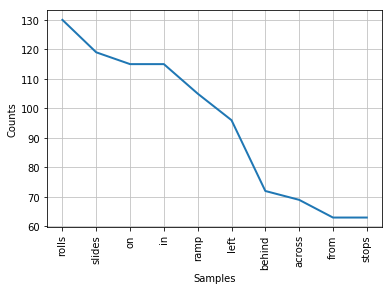

[('rolls', 130), ('slides', 119), ('on', 115), ('in', 115), ('ramp', 105), ('left', 96), ('behind', 72), ('across', 69), ('from', 63), ('stops', 63)]


In [16]:
for v, vector in enumerate([vector_clean,vector_clean_fail]):
    all_text_clean='/n'.join(vector)
    words=word_tokenize(all_text_clean)
    
    words_clean=[]
    for w in words:
        if w.lower() not in eng_stopwords:
            if w.isalpha():
                words_clean.append(w.lower())
    
    if v ==0:
        print('Success trials')
        words_clean_success=words_clean
    else:
        print('Fail trials')
        words_clean_fail=words_clean
        
    fDist=FreqDist(words_clean)
    fDist.plot(10)
    print(fDist.most_common(10))

(-0.5, 399.5, 199.5, -0.5)

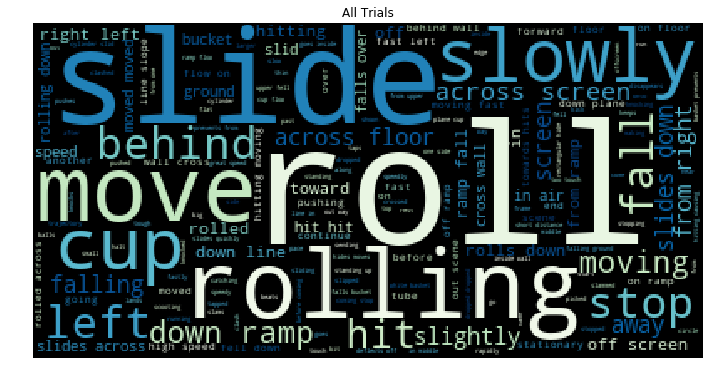

In [144]:
all_text_clean='/n'.join(vector_clean)
    
word_cloud=WordCloud(stopwords=[],colormap='GnBu').generate(all_text_clean)

plt.figure(figsize=(12,12))
plt.title('All Trials')
plt.imshow(word_cloud)
plt.axis("off")

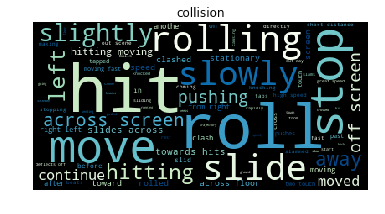

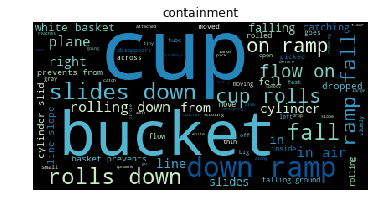

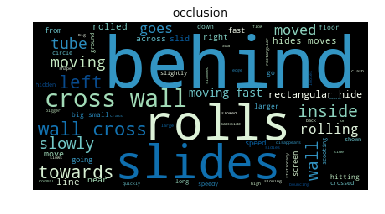

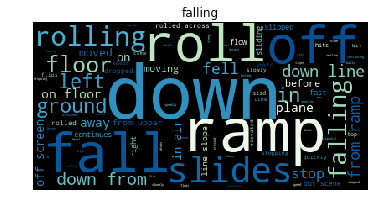

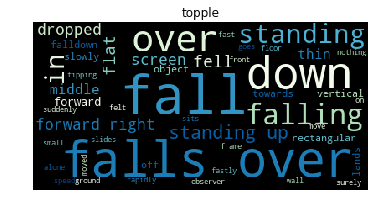

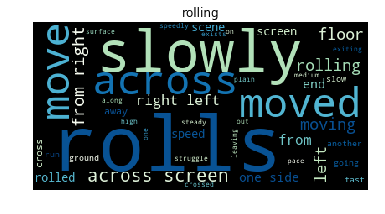

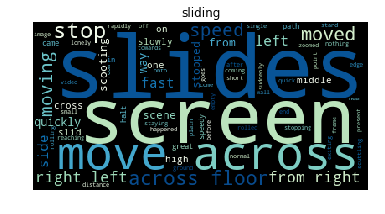

In [137]:
for t, trial_type in enumerate(trial_types):

    word_cloud=WordCloud(stopwords=[],colormap='GnBu').generate(vector_clean[t])

    plt.figure()
    plt.title(trial_type)
    plt.imshow(word_cloud)
    plt.axis("off")

In [179]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = eng_stopwords,
                                lowercase = True)


In [320]:
dtm_tf = tf_vectorizer.fit_transform(organized_trials)
print(dtm_tf.shape)

(910, 301)


In [290]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_topics=7, random_state=0,max_iter=50)
lda_tf.fit(dtm_tf)

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=7, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [292]:
output=pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)
output

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.240387  0.008004       1        1  23.707364
1     -0.060304 -0.280942       2        1  17.900552
0      0.018337  0.044716       3        1  17.796214
4      0.224070 -0.039637       4        1  10.788452
6     -0.133500 -0.015411       5        1  10.752923
5     -0.046993  0.285578       6        1  10.149152
3     -0.241997 -0.002307       7        1   8.905344, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
67    Default  142.000000         down  142.000000  30.0000  30.0000
135   Default   81.000000         left   81.000000  29.0000  29.0000
22    Default   62.000000       behind   62.000000  28.0000  28.0000
117   Default   57.000000         hits   57.000000  27.0000  27.0000
238   Default  126.000000       slides  126.000000  26.0000  26.0000
296   Default   45.000000         wall   45.000000  25.0000  25.0000
149   Default   45.000000        moved   45.000000  24.0000  24.0000
1     Default   74.000000       across   74.000000  23.0000  23.0000
161   Default   61.000000          off   61.000000  22.0000  22.0000
247   Default   61.000000       slowly   61.000000  21.0000  21.0000
193   Default  102.000000         ramp  102.000000  20.0000  20.0000
207   Default  136.000000        rolls  136.000000  19.0000  19.0000
56    Default   67.000000          cup   67.000000  18.0000  18.0000
216   Default   83.000000       screen   83.000000  17.0000  17.0000
93    Default   53.000000        floor   53.000000  16.0000  16.0000
151   Default   60.000000       moving   60.000000  15.0000  15.0000
203   Default   45.000000        right   45.000000  14.0000  14.0000
81    Default   45.000000         fall   45.000000  13.0000  13.0000
54    Default   28.000000        cross   28.000000  12.0000  12.0000
98    Default   74.000000         from   74.000000  11.0000  11.0000
205   Default   31.000000       rolled   31.000000  10.0000  10.0000
148   Default   37.000000         move   37.000000   9.0000   9.0000
88    Default   23.000000         fell   23.000000   8.0000   8.0000
138   Default   38.000000         line   38.000000   7.0000   7.0000
236   Default   22.000000         slid   22.000000   6.0000   6.0000
84    Default   51.000000        falls   51.000000   5.0000   5.0000
163   Default   46.000000           on   46.000000   4.0000   4.0000
86    Default   35.000000         fast   35.000000   3.0000   3.0000
121   Default   52.000000           in   52.000000   2.0000   2.0000
83    Default   35.000000      falling   35.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
177    Topic7    2.959983       picked    3.753199   2.1811  -4.6314
46     Topic7    2.959779         come    3.753231   2.1810  -4.6314
200    Topic7    7.612759  rectangular   10.261003   2.1200  -3.6867
112    Topic7    2.018494       hidden    2.811263   2.0872  -5.0142
76     Topic7    2.018080         ever    2.811249   2.0870  -5.0144
159    Topic7    2.018061       object    2.811265   2.0870  -5.0144
293    Topic7    2.017525     vertical    2.811241   2.0868  -5.0147
141    Topic7    1.076530       looses    1.869299   1.8667  -5.6428
113    Topic7    1.076530         hide    1.869299   1.8667  -5.6428
254    Topic7    1.076530        stand    1.869299   1.8667  -5.6428
53     Topic7    1.076529        crass    1.869299   1.8667  -5.6428
11     Topic7    1.076529      atopped    1.869299   1.8667  -5.6428
126    Topic7    1.076529       kicked    1.869299   1.8667  -5.6428
248    Topic7    1.076455        slows    1.869299   1.8666  -5.6429
286    Topic7    1.076219      tpramhe    1.869281   1.8664  -5.6431
267    Topic7    1.076111     struggle    1.869280   1.8663  -5.6432
142    Topic7    1.075859       losing    1.869287   1.8661  -5.6434
298    Topic7    1.07

In [183]:
pyLDAvis.save_html(output, 'lda_output.html')

In [250]:
vectorizer=TfidfVectorizer(norm=None,stop_words=eng_stopwords)
output=vectorizer.fit_transform(vector_input)
print(output.shape)

(7, 301)


In [185]:
feature_names = vectorizer.get_feature_names()
corpus_index = [n for n in vector_input]
import pandas as pd
df = pd.DataFrame(output.todense(), columns=feature_names, index=corpus_index)

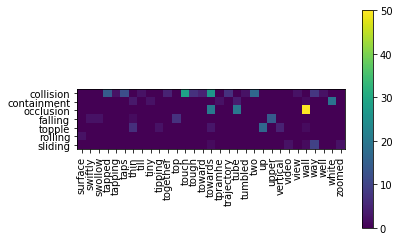

In [321]:
words_range=np.arange(270,301)

plt.imshow(np.array(df)[:,words_range],vmin=0,vmax=50)
plt.yticks(np.arange(len(trial_types)),labels=trial_types)
plt.xticks(np.arange(len(words_range)),labels=df.columns[words_range],rotation=90)
plt.colorbar()

In [187]:
df.to_csv('tfidf_events.csv')

In [189]:
for t, trial_type in enumerate(trial_types):
    print(trial_type)
    print(np.max(np.array(df)[t,:]))
    df_columns_sorted=df.columns[np.argsort(np.array(df)[t,:])]
    print(df_columns_sorted[-2:])
    print()

collision
110.92643816865666
Index(['hit', 'hits'], dtype='object')

containment
146.58136472286773
Index(['ramp', 'cup'], dtype='object')

occlusion
128.7539014457622
Index(['wall', 'behind'], dtype='object')

falling
110.92643816865666
Index(['down', 'ramp'], dtype='object')

topple
69.20253647247684
Index(['falls', 'over'], dtype='object')

rolling
33.4797338837463
Index(['across', 'rolls'], dtype='object')

sliding
26.07122203036402
Index(['across', 'slides'], dtype='object')



## Classification

In [16]:
vectorizer=TfidfVectorizer(norm=None,stop_words=eng_stopwords)
tfidf_data=vectorizer.fit_transform(organized_trials).toarray()
print(tfidf_data.shape)

(910, 301)


In [17]:
vectorizer=TfidfVectorizer(norm=None,stop_words=eng_stopwords)
tfidf_data=vectorizer.fit_transform(organized_trials).toarray()
print(tfidf_data.shape)

(910, 301)


In [18]:
fold=KFold(n_splits=10)
classifier = svm.LinearSVC(max_iter=2000)

scores=[]
confusions=[]
for train, test in fold.split(np.arange(len(organized_types))):
    X_train, X_test = tfidf_data[train], tfidf_data[test]
    y_train, y_test = organized_types[train], organized_types[test]
    
    classifier.fit(X_train, y_train) 

    score = classifier.score(X_test,y_test)
    scores.append(score)
    
    y_pred=classifier.predict(X_test) 
    confusion=confusion_matrix(y_test,y_pred)
    confusions.append(confusion)
    
print('Accuracy across folds:', scores)

Accuracy across folds: [0.6703296703296703, 0.6263736263736264, 0.8461538461538461, 0.8571428571428571, 0.6153846153846154, 0.7142857142857143, 0.7362637362637363, 0.8131868131868132, 0.7362637362637363, 0.5494505494505495]


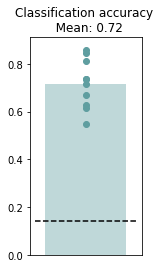

In [19]:
plt.figure(figsize=(2,4))
plt.title('Classification accuracy \n  Mean: %0.2f' %(np.nanmean(scores)))
plt.bar(1,np.nanmean(scores),alpha=0.4,color='cadetblue')
plt.scatter(np.ones(len(scores)),scores,color='cadetblue')
plt.xticks([])
chance=1/len(np.unique(organized_types))
plt.hlines(chance,0.5,1.5,linestyles='dashed')

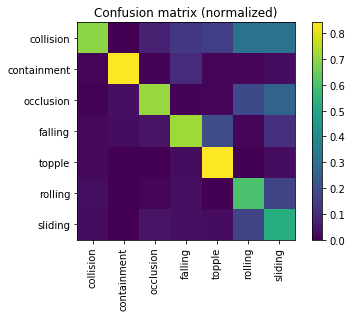

In [20]:
summed_confusions=sum(confusions)
normalized_confusions=summed_confusions/np.sum(summed_confusions,axis=1)

plt.title('Confusion matrix (normalized)')
plt.imshow(normalized_confusions)
plt.xticks(np.arange(len(trial_types)),trial_types,rotation=90)
plt.yticks(np.arange(len(trial_types)),trial_types)
plt.colorbar()

In [48]:
[ i for i in trial_types if i != 'rolling' and i != 'sliding']


['collision', 'containment', 'occlusion', 'falling', 'topple']

collision
(560, 230)


/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy across folds: [0.42857142857142855, 0.5714285714285714, 0.5357142857142857, 0.8214285714285714, 0.4107142857142857, 0.8392857142857143, 0.7142857142857143, 0.7857142857142857, 0.6785714285714286, 0.7678571428571429]
Average accuracy: 0.655357142857143
Ttest_1sampResult(statistic=3.0885951902547575, pvalue=0.012958830973551898)

containment
(420, 167)
Accuracy across folds: [0.9285714285714286, 1.0, 0.8571428571428571, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 0.9285714285714286]
Average accuracy: 0.9642857142857144
Ttest_1sampResult(statistic=29.068883707497267, pvalue=3.289965245758492e-10)

occlusion
(420, 151)
Accuracy across folds: [0.4642857142857143, 0.39285714285714285, 0.39285714285714285, 0.8214285714285714, 0.4642857142857143, 0.42857142857142855, 0.6428571428571429, 0.7142857142857143, 0.8928571428571429, 0.6428571428571429]
Average accuracy: 0.5857142857142857
Ttest_1sampResult(statistic=1.4808421256215092, pvalue=0.17278514640326154)

falling
(420, 163)
Accurac

([<matplotlib.axis.XTick at 0x2b44b6acaba8>,
 <a list of 5 Text xticklabel objects>)

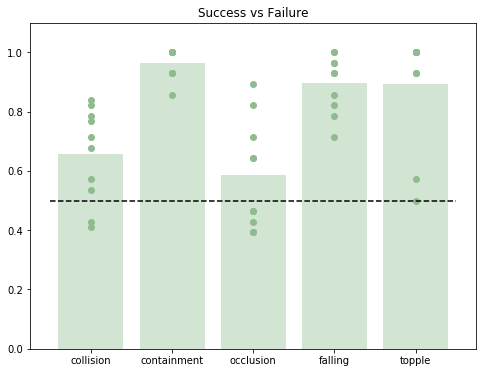

In [123]:
plt.figure(figsize=(8,6))
plt.ylim(0,1.1)
plt.title('Success vs Failure')

# No failures in these two event types
s_f_types=[ i for i in trial_types if i != 'rolling' and i != 'sliding']
all_confusions=[]

# Each success/fail
for t, trial in enumerate(s_f_types):
    print(trial)
        
    success_fail_trials=np.hstack((organized_trials[organized_types==t],failed_trials[failed_types==0]))
    success_fail_types=np.hstack((np.zeros(len(organized_trials[organized_types==t]))
                                      ,np.ones(len(organized_trials[organized_types==t]))))
        
    vectorizer=TfidfVectorizer(norm=None,stop_words=eng_stopwords)
    tfidf_data=vectorizer.fit_transform(success_fail_trials).toarray()
    print(tfidf_data.shape)

        
    fold=KFold(n_splits=10)
    classifier = svm.LinearSVC(max_iter=2000)

    scores=[]
    confusions=[]
 
    for train, test in fold.split(np.arange(len(success_fail_types))):
        X_train, X_test = tfidf_data[train], tfidf_data[test]
        y_train, y_test = success_fail_types[train], success_fail_types[test]

        classifier.fit(X_train, y_train) 

        score = classifier.score(X_test,y_test)
        scores.append(score)

        y_pred=classifier.predict(X_test) 
        confusion=confusion_matrix(y_test,y_pred)
        confusions.append(confusion)

    print('Accuracy across folds:', scores)
    print('Average accuracy:',np.nanmean(scores))
    print(stats.ttest_1samp(scores,0.5))
    print()
        
    all_confusions.append(confusions)    

    plt.bar(t,np.nanmean(scores),alpha=0.4,color='darkseagreen')
    plt.scatter(t*np.ones(len(scores)),scores,color='darkseagreen')


chance=0.5
plt.hlines(chance,-0.5,len(s_f_types)-0.5,linestyles='dashed')
        
plt.xticks(np.arange(len(s_f_types)),s_f_types)

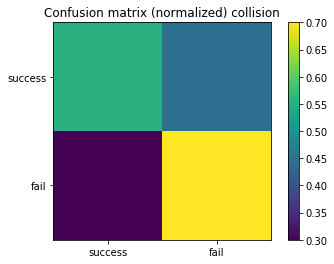

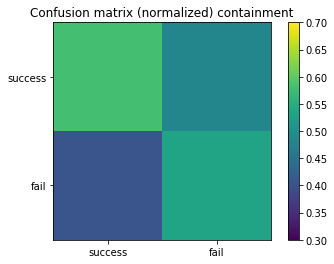

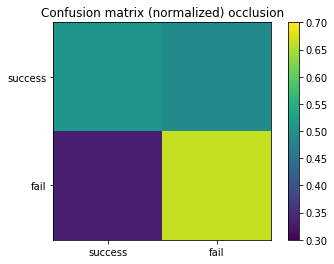

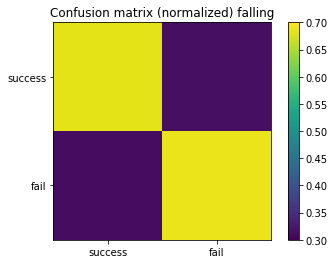

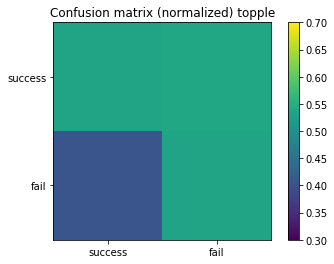

In [127]:
for t,trial in enumerate(s_f_types):
    summed_confusions=sum(all_confusions[t])
    normalized_confusions=summed_confusions/np.sum(summed_confusions,axis=1)
    
    plt.figure()
    plt.title('Confusion matrix (normalized) %s' %(trial))
    plt.imshow(normalized_confusions,vmin=0.3,vmax=0.7)
    plt.xticks(np.arange(2),['success','fail'])
    plt.yticks(np.arange(2),['success','fail'])
    plt.colorbar()

In [17]:
import pandas as pd

topple
Most distinctive for success: Index(['fall', 'standing', 'down', 'over', 'falls'], dtype='object')
Most distinctive for fail: Index(['stand', 'in', 'standing', 'shake', 'slightly'], dtype='object')
Index(['slightly', 'shake', 'wobbles', 'stationary', 'stand'], dtype='object')
Index(['right', 'fell', 'down', 'over', 'falls'], dtype='object')


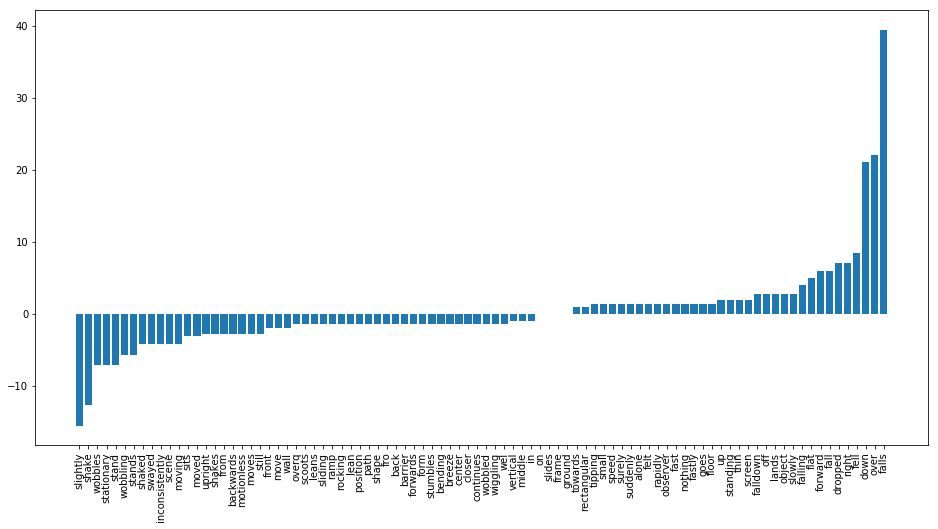

In [61]:
# Why is containment so good?
# Each success/fail
trial='topple'
t=np.where(np.array(trial_types)==trial)[0][0]
print(trial)

success=('\n').join(organized_trials[organized_types==t])
fail=('\n').join(failed_trials[failed_types==t])

vectorizer=TfidfVectorizer(norm=None,stop_words=eng_stopwords)
tfidf_data=vectorizer.fit_transform([success,fail])

feature_names = vectorizer.get_feature_names()
corpus_index = [n for n in ['succcess','fail']]
df = pd.DataFrame(tfidf_data.todense(), columns=feature_names, index=corpus_index)

success_sorted=df.columns[np.argsort(np.array(df)[0,:])]
print('Most distinctive for success:',success_sorted[-5:])
fail_sorted=df.columns[np.argsort(np.array(df)[1,:])]
print('Most distinctive for fail:',fail_sorted[-5:])


differences=np.array(df)[0,:]-np.array(df)[1,:]
sorted_diffs=differences[np.argsort(differences)]
sorted_words=df.columns[np.argsort(differences)]

plt.figure(figsize=(16,8))
plt.bar(np.arange(len(sorted_words)),sorted_diffs)
plt.xticks(np.arange(len(sorted_words)),sorted_words,rotation=90)
print(sorted_words[:5])
print(sorted_words[-5:])

In [19]:
vectorizer=TfidfVectorizer(norm=None,stop_words=eng_stopwords)
tfidf_data=vectorizer.fit_transform(np.hstack((organized_trials,failed_trials))).toarray()
print(tfidf_data.shape)

combined_types=np.hstack((organized_types,failed_types+len(np.unique(organized_types))))
print(np.unique(combined_types))

(1680, 420)
[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [20]:
combined_names=[]

for prefix in ['success ','fail ']:
    for trial in trial_types:
        if prefix=='fail ':
            if trial!='sliding' and trial!='rolling':
                combined_names.append(prefix+trial)
        else:
            combined_names.append(prefix+trial)

print(combined_names)

['success collision', 'success containment', 'success occlusion', 'success falling', 'success topple', 'success rolling', 'success sliding', 'fail collision', 'fail containment', 'fail occlusion', 'fail falling', 'fail topple']


In [184]:
np.unique(y_test)

array([ 7,  8,  9, 10, 11])

In [188]:
np.unique(y_pred)

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11])

In [183]:
confusion_matrix(y_test,y_pred).shape

(11, 11)

In [201]:
fold=KFold(n_splits=5)
classifier = svm.LinearSVC(max_iter=2000)

scores=[]
confusions=[]
for train, test in fold.split(np.arange(len(combined_types))):
    X_train, X_test = tfidf_data[train], tfidf_data[test]
    y_train, y_test = combined_types[train], combined_types[test]
    
    classifier.fit(X_train, y_train) 

    score = classifier.score(X_test,y_test)
    scores.append(score)
    
    y_pred=classifier.predict(X_test) 
    confusion=confusion_matrix(y_test,y_pred)
    confusions.append(confusion)
    
print('Accuracy across folds:', scores)

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy across folds: [0.39285714285714285, 0.36904761904761907, 0.32142857142857145, 0.35714285714285715, 0.2261904761904762]


/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [202]:
for c in confusions:
    print(c.shape)

(12, 12)
(12, 12)
(12, 12)
(12, 12)
(12, 12)


Chance: 0.08333333333333333


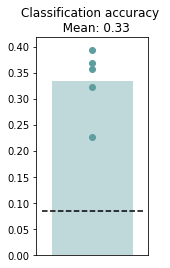

In [203]:
plt.figure(figsize=(2,4))
plt.title('Classification accuracy \n  Mean: %0.2f' %(np.nanmean(scores)))
plt.bar(1,np.nanmean(scores),alpha=0.4,color='cadetblue')
plt.scatter(np.ones(len(scores)),scores,color='cadetblue')
plt.xticks([])
chance=1/len(np.unique(combined_types))
print('Chance:',chance)
plt.hlines(chance,0.5,1.5,linestyles='dashed')

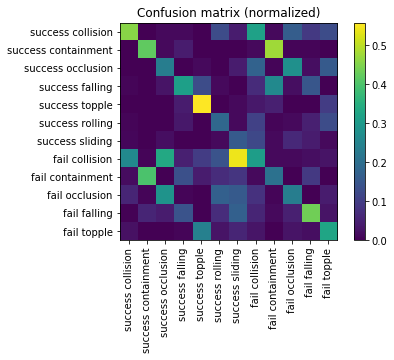

In [204]:
summed_confusions=sum(confusions)
normalized_confusions=summed_confusions/np.sum(summed_confusions,axis=1)

plt.title('Confusion matrix (normalized)')
plt.imshow(normalized_confusions)
plt.xticks(np.arange(len(combined_names)),combined_names,rotation=90)
plt.yticks(np.arange(len(combined_names)),combined_names)
plt.colorbar()

## Cross-Validated Topic Models

280

In [109]:
## We want the /lowest/ perplexity

tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = eng_stopwords,
                                lowercase = True)
t=4
trial=trial_types[t]
print(trial)

trial_data=organized_trials[organized_types==t]

kfold=KFold(n_splits=2)

topic_perplex=[]
topic_loglik=[]

for n in range(2,10):
    perplex=[]
    loglik=[]
    print(n)
    for train,test in kfold.split(trial_data):
        dtm_tf = tf_vectorizer.fit_transform(trial_data)
        dtm_train = dtm_tf[train]
        dtm_test= dtm_tf[test]
        #print(dtm_train.shape)
        #print(dtm_test.shape)

        # for TF DTM
        lda_tf = LatentDirichletAllocation(n_topics=n, random_state=0,max_iter=50)
        lda_tf.fit(dtm_train)

        perplex.append(lda_tf.perplexity(dtm_test))
        loglik.append(lda_tf.score(dtm_test))
        
    topic_perplex.append(np.mean(perplex))
    topic_loglik.append(np.mean(loglik))
          
                

topple
2


/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


3


/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


4


/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


5


/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


6


/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


7


/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


8


/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


9


/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


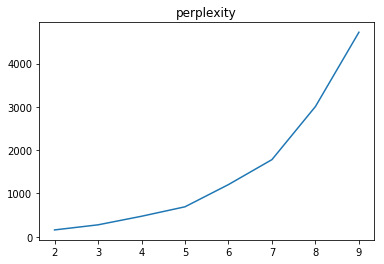

In [112]:
plt.title('perplexity')
plt.plot(np.arange(2,10),topic_perplex)

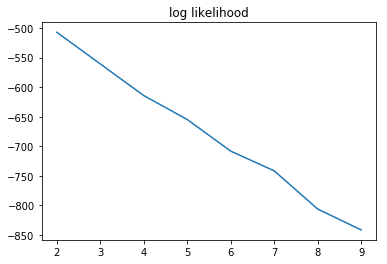

In [114]:
plt.title('log likelihood')
plt.plot(np.arange(2,10),topic_loglik)